In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from scipy.optimize import linear_sum_assignment
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten, Conv2D, MaxPool2D,Conv2DTranspose,Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import itertools
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.optimizers import SGD

In [2]:
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
y_test = [np.argmax(y)for y in y_test]
y_train = [np.argmax(y)for y in y_train]
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x=x.reshape((10015,22500))
print(x.shape)
train=True

(10015, 22500)


In [3]:
def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [4]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [5]:
dims = [x.shape[-1], 5000, 3000, 2000,1000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=0.1, momentum=0.9)
pretrain_epochs = 150
batch_size = 20
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.summary()
print(dims)

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 22500)]           0         
_________________________________________________________________
encoder_0 (Dense)            (None, 5000)              112505000 
_________________________________________________________________
encoder_1 (Dense)            (None, 3000)              15003000  
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              6002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 1000)              2001000   
_________________________________________________________________
encoder_4 (Dense)            (None, 10)                10010     
_________________________________________________________________
decoder_4 (Dense)            (None, 1000)              11000    

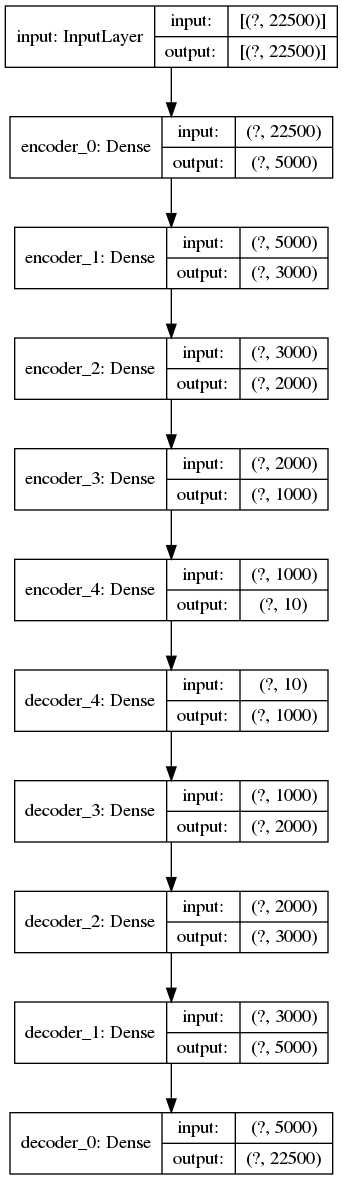

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png') 

In [ ]:
if train==True:
    autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
    history=autoencoder.fit(x,x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
    autoencoder.save_weights('./ae_weights1.h5')

Train on 10015 samples
Epoch 1/150
10015/10015 [==============================] - 19s 2ms/sample - loss: 0.6529
Epoch 2/150
10015/10015 [==============================] - 12s 1ms/sample - loss: 0.4551
Epoch 3/150
10015/10015 [==============================] - 12s 1ms/sample - loss: 0.3752
Epoch 4/150
10015/10015 [==============================] - 12s 1ms/sample - loss: 0.3158
Epoch 5/150
10015/10015 [==============================] - 12s 1ms/sample - loss: 0.4802
Epoch 6/150
10015/10015 [==============================] - 12s 1ms/sample - loss: 0.4036
Epoch 7/150
10015/10015 [==============================] - 12s 1ms/sample - loss: 0.3118
Epoch 8/150
10015/10015 [==============================] - 12s 1ms/sample - loss: 0.2764
Epoch 9/150
10015/10015 [==============================] - 12s 1ms/sample - loss: 0.2355
Epoch 10/150
10015/10015 [==============================] - 12s 1ms/sample - loss: 0.2327
Epoch 11/150
10015/10015 [==============================] - 12s 1ms/sample - loss: 0.2